# Исследование сервиса аренды самокатов GoFast.

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

Данные состят из 3 массивов с информацией о поездках, покупателях и  тарифах.

**Цель проекта:**

- Проанализировать данные пользователей приложения.
- Рассмотреть различия и общие закономерности для пользователей без подписки и с.

**Ход проекта:**

1. Загрузка данных
   
    * Загрузить данные
    * Проанализировать данные и конкретизировать план работ.

2. Предобработка данных
   
    *  Поправить форматы. 
    *  Создание новых признаков, при необходимости.
    *  Проверить наличие пропущенных значений и дубликатов в датафреймах. Обработать их, если такие значения присутствуют.

3. Исследовательский анализ данных

Описать и визуализировать общую информацию о пользователях и поездках:

   *  частота встречаемости городов;
   *  соотношение пользователей с подпиской и без подписки;
   *  возраст пользователей;
   *  расстояние, которое пользователь преодолел за одну поездку;
   *  продолжительность поездок.


4. Объединение данных

    *  Объедините данные о пользователях, поездках и подписках в один датафрейм. 
    *  Исследовать  информацию о поездках и покупателях. Визулизировать при необходимости.

5. Подсчёт выручки

6. Проверка гипотез


## Загрузка данных 
([к содержанию](#1))

In [1]:
#Импортирую необходимые нам бибилиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
from scipy import stats as st

In [2]:
#Выгружаю данные
try:
    users = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/3 go_fast/users_go.csv')
    rides_go = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/3 go_fast/rides_go.csv')
    subscriptons = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/3 go_fast/subscriptions_go.csv')
except:
    users = pd.read_csv('/datasets/users_go.csv')
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    subscriptons = pd.read_csv('/datasets/subscriptions_go.csv')

Рассмотрим повнимательнее каждый из них.

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В этом датафрейме предcтавлены данные о 1565 пользователях.   

* user_id -	уникальный идентификатор пользователя
* name - имя пользователя
* age -	возраст
* city - город
* subscription_type	- тип подписки (free, ultra)

  На первый взгляд пропуски отсутсвуют. 

In [5]:
rides_go.head()


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Здесь представлена информация о 18068 поездках:

* user_id -	уникальный идентификатор пользователя
* distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date - дата совершения поездки

    Пропуски отсутсвуют. Нужно будет привести данные в графе date к временному типу данных.

In [7]:
subscriptons.head(15)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки 
    абонентская плата отсутствует;
    стоимость одной минуты поездки — 8 рублей;
    стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra 
    абонентская плата — 199 рублей в месяц;
    стоимость одной минуты поездки — 6 рублей;
    стоимость старта — бесплатно.

Это, судя по данным, таблица с расшифровкой тарифов:

* subscription_type	- тип подписки
* minute_price	стоимость  - одной минуты поездки по данной подписке
* start_ride_price	- стоимость начала поездки
* subscription_fee	- стоимость ежемесячного платежа

_____________
**Прoмежуточный вывод:**

- Мы импортипровали массивы данных и рассмотрели их чуть подробнее. 
- Пропусков не выявлено.
- В таблице rides_gp нужно привести данные в графе date к временному типу данных.

## Предобработка данных.

Меняем формат в таблице rides_go, в графе date.

Рассмотрим временной диапазон данных.

Добавим столбец в котором будет указан просто месяц.

In [8]:
#меняем формат данных в столбце
rides_go['date'] = pd.to_datetime(
    rides_go['date'], format = '%Y-%m-%d')

print('Диапазон дат', rides_go['date'].min(), '-', rides_go['date'].max())

Диапазон дат 2021-01-01 00:00:00 - 2021-12-30 00:00:00


В данных представлена информация о поездках совершенных с 1-го января 2021 года по 30-е декабря 2021.

Почти целый год.

Добавим столбец в котором будет указан просто месяц.

In [9]:

rides_go['month'] = pd.DatetimeIndex(rides_go['date']).month


Округлим значения в столбце в длительностью поездки до целых минут.

In [10]:
rides_go['duration'] = np.ceil(rides_go['duration']) 

Проверим датафреймы на на наличиe пропусков

In [11]:
print('Количество пропусков в таблице с данными о пользователях:', users.isna().sum())
print(users.isna().sum())

Количество пропусков в таблице с данными о пользователях: user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [12]:
print('Количество пропусков в таблице с данными о поездках:')
print(rides_go.isna().sum())

Количество пропусков в таблице с данными о поездках:
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


Проверим датафреймы на на наличиe дублей

In [13]:
print('Количество дублей в таблице с данными о пользователях:', users.duplicated().sum())

Количество дублей в таблице с данными о пользователях: 31


In [14]:
dubl_users = users[users.duplicated()]
dubl_users

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Начиная с 1534 строки появляются уже зарегестрированные ранее пользователи. Это говорит нам о какой-то ошибке, или на стадии регистрации, или на стадии выгрузки данных.
Дубликаты удалим, а информацию об ошибке передадим в соответсвующий отдел.

In [15]:
#Удаляю дубли и перезаписываю данные
users = users.drop_duplicates()
print('Количество дублей в таблице с данными о пользователях:', users.duplicated().sum())

Количество дублей в таблице с данными о пользователях: 0


In [16]:
print('Количество дублей в таблице с данными о поездках:', rides_go.duplicated().sum())

Количество дублей в таблице с данными о поездках: 0


________
**Промежуточный выод:**

* На данном этапе работы мы приобразовали данные в столбце с датой, в данных о поездках. 


* Округлили данные о длительности поездки до целых минут.


* Добавили новый столбец с указанием месяца, в этот же датафрейм.


* Проверили данные на наличие пропусков.

Пропусков не выявлено.


* Проверили данные на наличие дубликатов.

***ВАЖНО:*** В таблице с данными о пользователях дублируются данные начиная с 1534 строки. Скорее всего тут произошла ошибка, или при регистрации пользователя, или при выгрузке данных.

Дубликаты удалены.

В таблице с информацией о поздках тдубликатов не обнаружено.

##  Исследовательский анализ данных.

### Частота встречаемости городов

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


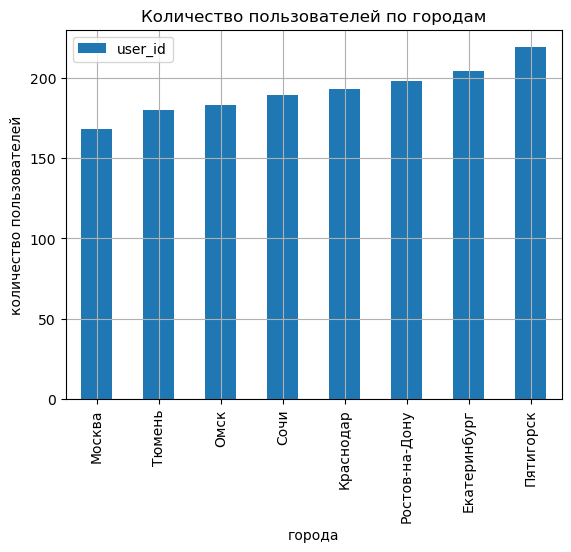

In [17]:
print(users['city'].value_counts())
(
    users.pivot_table(index = 'city',
                     values = 'user_id',
                     aggfunc = 'count')
    .sort_values('user_id')
    .plot(kind='bar',
         title = 'Количество пользователей по городам', 
         xlabel = 'города',
         ylabel = 'количество пользователей',
         grid=True)
);

Меньше всего пользователей приложения GoFast в Москве, всего 168.

Больше всего в Пятигорске - 219.

### Соотношение пользователей с и без подписки.

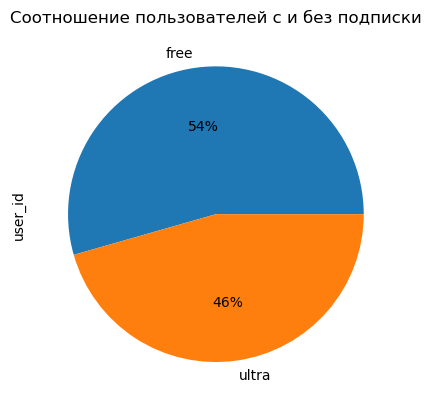

In [18]:
(
    users.groupby('subscription_type')['user_id'].count()
    .plot(kind='pie',
          autopct = '%1.0f%%',
         title='Соотношение пользователей с и без подписки')
);

Среди пользователей приложение 54% без подписки, против 46% с подпиской.

Пользователей без подписки больше, но всего процентов на 8, а значит у компании-прокатчика есть неплохая база постоянных клиентов.


### Возраст пользователей

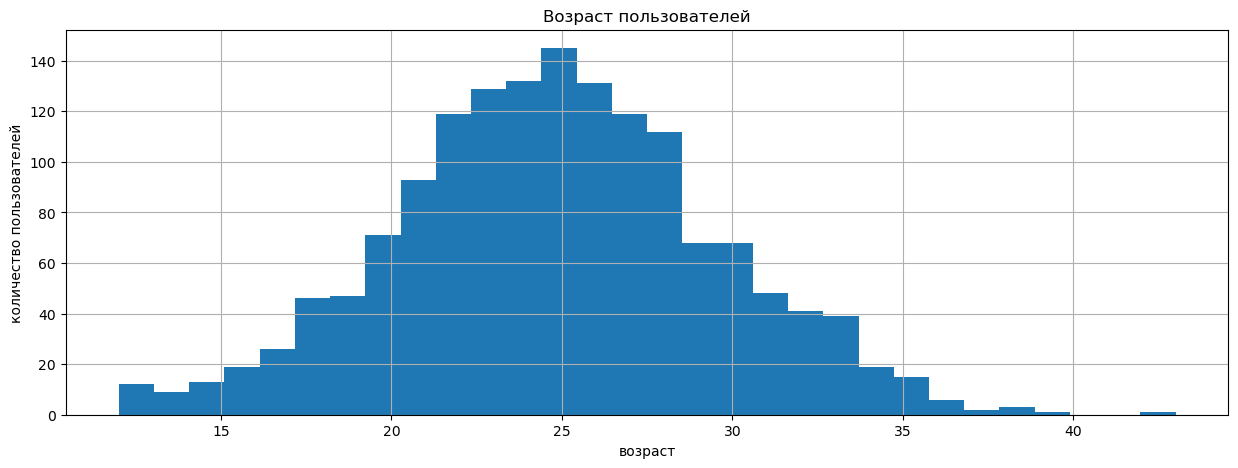

In [19]:
users['age'].hist(bins=30, figsize=(15,5))
plt.title('Возраст пользователей')
plt.xlabel('возраст')
plt.ylabel('количество пользователей');

Среди пользователей чаще встречаются люди возраста от 20 до 28 лет.

Чаще остальных пользуются этим приложением 25-летние.

### Расстояние которое пользователь преодолел за одну поездку.

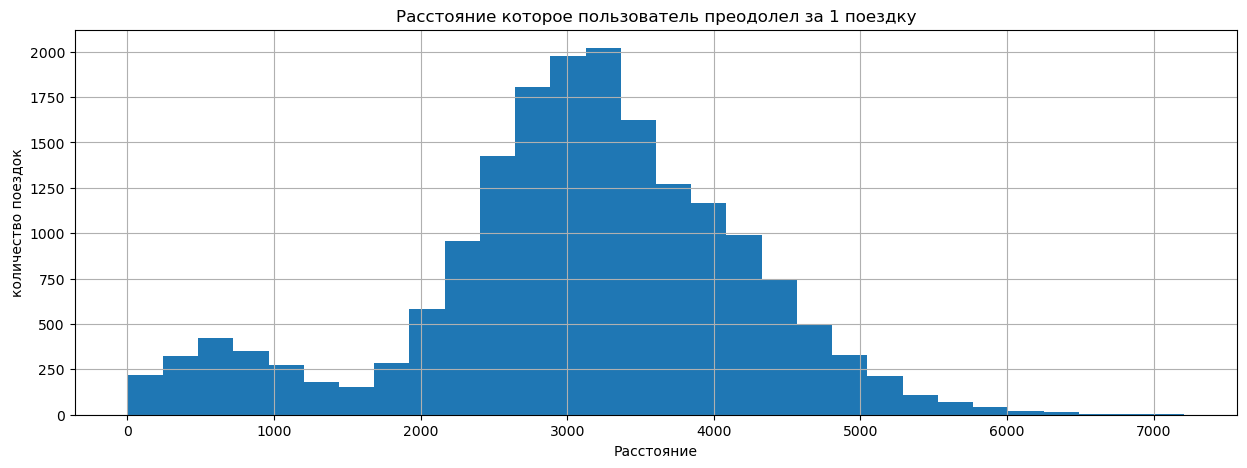

In [20]:
rides_go['distance'].hist(bins=30, figsize=(15,5))
plt.title('Расстояние которое пользователь преодолел за 1 поездку')
plt.xlabel('Расстояние')
plt.ylabel('количество поездок');

Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.

### Продолжительность поездок

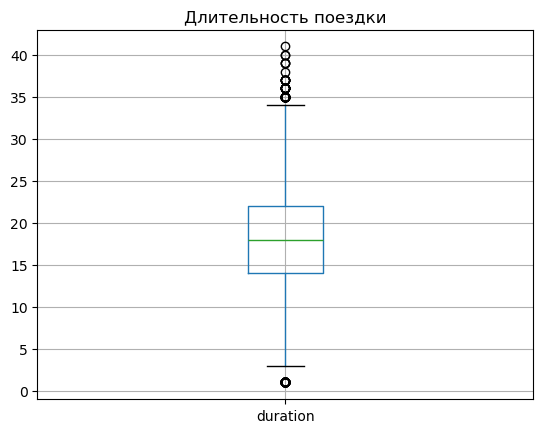

In [21]:
rides_go.boxplot('duration')
plt.title('Длительность поездки');

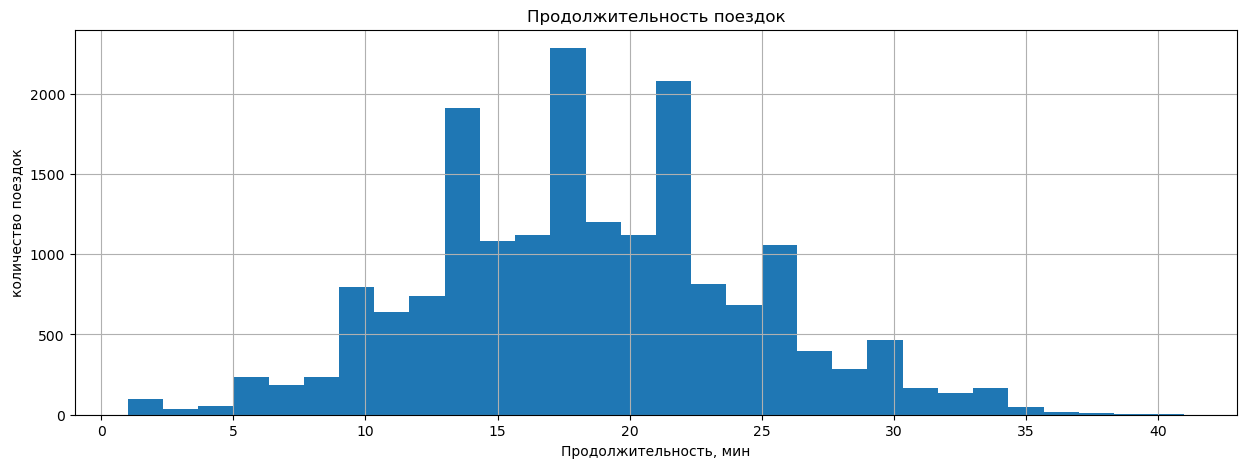

In [22]:
rides_go['duration'].hist(bins=30, figsize=(15,5));
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность, мин')
plt.ylabel('количество поездок');

Чаще всего поездки длятся от 10 до 23 минут.

Пиковые значения: 12, 17 и 22 минуты.

_______
**Промежуточный вывод:**

* Меньше всего пользователей приложения GoFast в Москве, всего 168.

Больше всего в Пятигорске - 219.

* Среди пользователей приложение 54% без подписки, против 46% с подпиской.

Пользователей без подписки больше, но всего процентов на 8, а значит у компании-прокатчика есть неплохая база постоянных клиентов.


* Среди пользователей чаще встречаются люди возраста от 20 до 28 лет.

Чаще остальных пользуются этим приложением 25-летние.

* Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.


* Чаще всего поездки длятся от 10 до 23 минут.

Пиковые значения: 12, 17 и 22 минуты.


## Объеденение данных.

### Таблица пользователи-поездки.

Объединим данные о пользователях, поездках и разъяснительной информацией о тарифах в 1 датафрейм и посмотрим получившуюся таблицу.

Для начала оценим размеры наших таблиц.

In [23]:
dfs = [users, rides_go, subscriptons]


for d in dfs:
    print('Размер таблицы - ', d.shape)
    print('Столбцы:', d.columns.values.tolist())
    print()

Размер таблицы -  (1534, 5)
Столбцы: ['user_id', 'name', 'age', 'city', 'subscription_type']

Размер таблицы -  (18068, 5)
Столбцы: ['user_id', 'distance', 'duration', 'date', 'month']

Размер таблицы -  (2, 4)
Столбцы: ['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']



Итак, первая таблица состоит из 1534 строк с данными о пользователях.
Во второй данные о 18 068 поездках.
И в третьей 2 строки и 4 столбца описывающие параметры поездки, название тарифа, стоимость минуты, стоимость старта и и стоимость тарифа.

На основании этого мы можем сделать общую таблицу, в которой будут данные о 18 068 поездках дополненные информацией о пользователе и его тарифе, с рашифровкой всех цен.



In [24]:
# Создаю таблицу

general = (
    users.merge(rides_go,
                     on = 'user_id',
                     how = 'left')
    .merge(subscriptons,
          on = 'subscription_type',
          how = 'left')
)
general.head(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,17.0,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,15.0,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,24.0,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,16.0,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,16.0,2021-11-22,11,6,0,199


In [25]:
print('Размер общей таблицы - ', general.shape)
print()
print('Общая информация о столбцах:', general.info())

Размер общей таблицы -  (18068, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1

Общая таблица содержит данные о 18 068 поездках дополненные информацией о пользователе и его тарифе, с рашифровкой всех цен.

Прропусков нет.

### Отдельные дата-фреймы с пользователями с подпиской и без.

Создадим 2 отдельных дата-фрейма, с данными о пользователях без подписки, и пользователях с подпиской.

In [26]:
#Датафрейм с информацией о пользователях без подписки

free = general.query('subscription_type == "free"')
free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


В датафрейме о пользователях без подписки информация о 11 568 поездках.

In [27]:
#Датафрейм с информацией о пользователях с подпиской
ultra = general.query('subscription_type == "ultra"')
ultra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB


В датафрейме о пользователях c подпиской информация о 6 500 поездках.

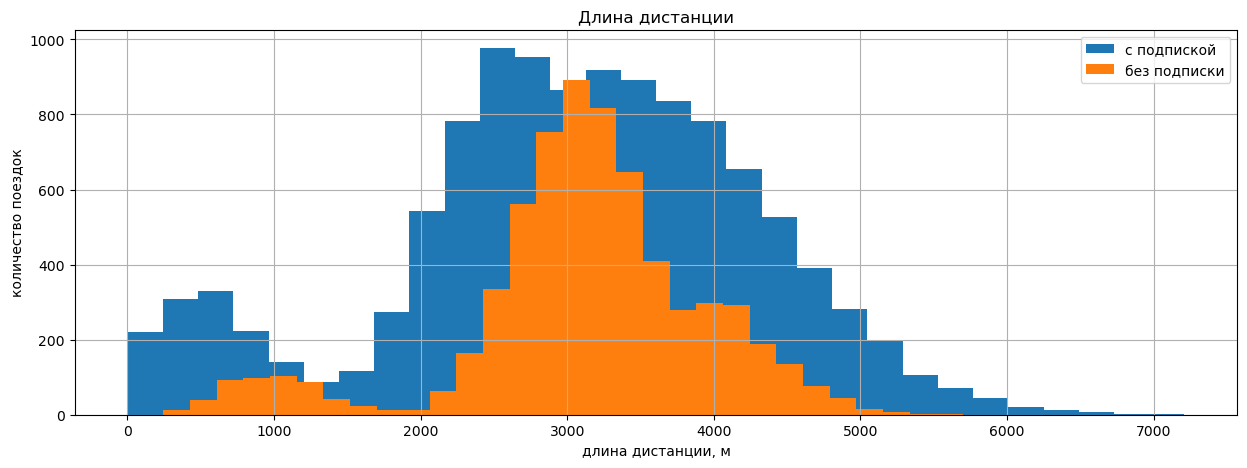

In [28]:
free['distance'].hist(bins=30, figsize=(15,5));
ultra['distance'].hist(bins=30, figsize=(15,5));
plt.legend(['с подпиской', 'без подписки'])
plt.xlabel('длина дистанции, м')
plt.ylabel('количество поездок');
plt.title('Длина дистанции');

Судя по графику, длина дистанции поездки у пользователей сподпиской больше чем у пользователей без подписки.

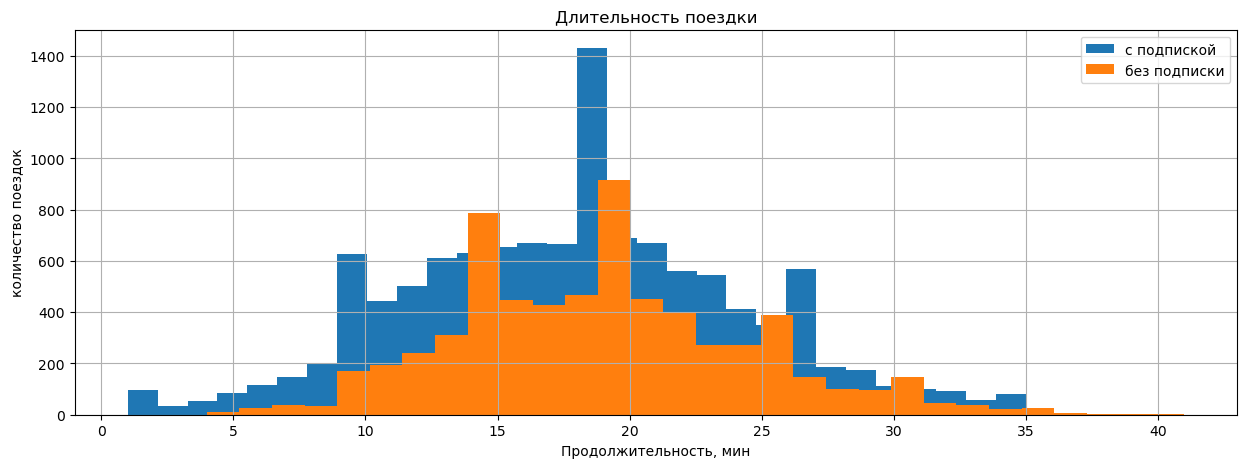

In [29]:
free['duration'].hist(bins=30, figsize=(15,5));
ultra['duration'].hist(bins=30, figsize=(15,5));
plt.legend(['с подпиской', 'без подписки'])
plt.title('Длительность поездки')
plt.xlabel('Продолжительность, мин')
plt.ylabel('количество поездок');

Судя по графику, длительность поездки у пользователей сподпиской больше чем у пользователей без подписки.
________
**Промежуточный вывод:**

В этой части работы из трех исходных датафреймов я создала новые:

- Общий, 'general'. Включает в себя информацию о пользователях, о поездках и расшифровка тарифов. 

- 'ultra', Только информация о поездках пользователей с подпиской.

- 'free', Только информация о поездках пользователей без подписки.

- Визаулизировала на графиках данные о длительности и длине поездок пользователей без/с подпиской. 
У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

## Подсчет выручки

### Расчет месячных показателей.

Перед проведение расчетов, проверим данные на пропуски.

In [30]:
pd.DataFrame(round(general.isna().mean() * 100)).style.background_gradient('coolwarm')

,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000
minute_price,0.000000


Данные чистые, пропусков не обнаружено.

In [31]:
#Агрегируем таблицу, чтобы увидеть необходимые данные о поездках
profit = general.pivot_table(index = ['month','user_id'],
                            values = ['distance', 'duration', 'subscription_type', 'minute_price', 
                                      'start_ride_price', 'subscription_fee'],
                            aggfunc = {'distance' : ['count', 'sum'],
                                       'duration' : 'sum',
                                       'subscription_type':'first',
                                       'minute_price':'first',
                                       'start_ride_price':'first',
                                       'subscription_fee':'first'}
                                       )
#Уберем мультииндексы 
profit.columns = ['total_drives', 'total_distance', 'total_duration', 'minute_price', 
                  'start_ride_price', 'subscription_fee','subscription_type']

profit


total_drives  total_distance  total_duration  minute_price  \
month user_id                                                               
1     1                   2     7027.511294            42.0             6   
      3                   1     3061.777147            13.0             6   
      5                   1     3914.646990            13.0             6   
      7                   2     6478.080979            28.0             6   
      12                  1     3577.151148            33.0             6   
...                     ...             ...             ...           ...   
12    1525                1     4597.854350            34.0             8   
      1526                1     3644.121544            23.0             8   
      1528                1     3998.569324            11.0             8   
      1532                2     6111.889853            42.0             8   
      1534                1     2371.711192            16.0             8   

               start_ride_price  subscription_fee subscription_type  
month user_id                                                        
1     1                       0               199             ultra  
      3                       0               199             ultra  
      5                       0               199             ultra  
      7                       0               199             ultra  
      12                      0               199             ultra  
...                         ...               ...               ...  
12    1525                   50                 0              free  
      1526                   50                 0              free  
      1528                   50                 0              free  
      1532                   50                 0              free  
      1534                   50                 0              free  

[11331 rows x 7 columns]

In [32]:
#Расчитаем прибыль которую принес каждый пользователь

profit['total_profit'] = profit['start_ride_price'] * profit['total_drives'] + \
profit['minute_price'] * profit['total_duration']  + profit['subscription_fee']

profit

total_drives  total_distance  total_duration  minute_price  \
month user_id                                                               
1     1                   2     7027.511294            42.0             6   
      3                   1     3061.777147            13.0             6   
      5                   1     3914.646990            13.0             6   
      7                   2     6478.080979            28.0             6   
      12                  1     3577.151148            33.0             6   
...                     ...             ...             ...           ...   
12    1525                1     4597.854350            34.0             8   
      1526                1     3644.121544            23.0             8   
      1528                1     3998.569324            11.0             8   
      1532                2     6111.889853            42.0             8   
      1534                1     2371.711192            16.0             8   

               start_ride_price  subscription_fee subscription_type  \
month user_id                                                         
1     1                       0               199             ultra   
      3                       0               199             ultra   
      5                       0               199             ultra   
      7                       0               199             ultra   
      12                      0               199             ultra   
...                         ...               ...               ...   
12    1525                   50                 0              free   
      1526                   50                 0              free   
      1528                   50                 0              free   
      1532                   50                 0              free   
      1534                   50                 0              free   

               total_profit  
month user_id                
1     1               451.0  
      3               277.0  
      5               277.0  
      7               367.0  
      12              397.0  
...                     ...  
12    1525            322.0  
      1526            234.0  
      1528            138.0  
      1532            436.0  
      1534            178.0  

[11331 rows x 8 columns]

## Проверка гипотез.

### Гипотеза Пользователи с подпиской тратят больше времени на поездки.

In [33]:
#Нулевая гипотеза - длительность поездки пользователей с подпиской равна длительности пользователя без подкписки
#Альтернативная, длительность пользователей с подпиской больше
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(
    ultra['duration'], 
    free['duration'],
    alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
    

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


Есть все основания предполагать, что длительность поездки пользователей с подпиской больше пользователей без подписки.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 


In [34]:
#Нулевая гипотеза: Расстояние которое проезжают пользователи за одну поездку равно 3130 м.
#Альтернативная: Расстояние которое проезжают пользователи за одну поездку больше 3130 м

wear = 3130
alphа = .05 #уровень статистической значимости

results = st.ttest_1samp(
    ultra['distance'],
    wear,
    alternative = 'greater'
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


На основании полученных данных можно предположить, что длина поездок менее 3130 м.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

In [35]:
# Нулевая гипотеза - помесячная выручка от пользователей с подпиской по месяцам ==, чем выручка от 
#пользователей без подписки
# Альтернативная - помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от 
#пользователей без подписки

alphа = .05 #уровень статистической значимости

results = st.ttest_ind(
    profit.query('subscription_type == "ultra"')['total_profit'],
    profit.query('subscription_type == "free"')['total_profit'],
    alternative = 'greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Да, есть все основания полагать что выручка по месяцам пользователей с подпиской, больше чем выручка пользователей без подписки.

### Распределения

#### Задача 1.

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно  5%. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

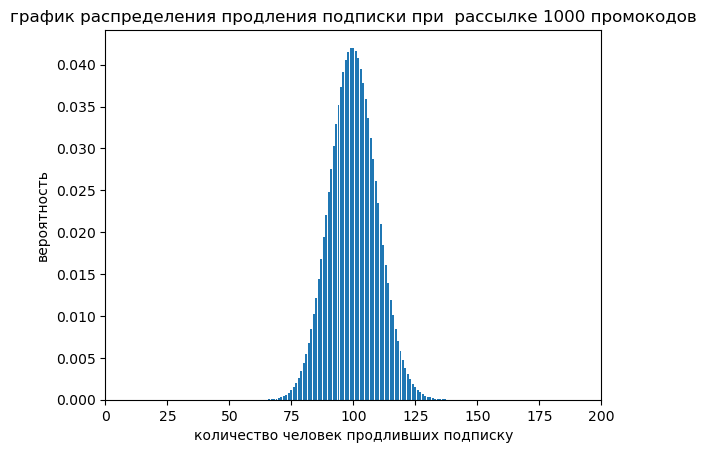

In [36]:
#Построим график распределения продления подписки при  рассылке 1000 промокодов

n = 1000 #количество промокодов
p = 0.1 #вероятноть успеха(того, что подписку продлят)

distr = [] #пустой список для построения бинминального распределения

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);


plt.xlim(0, 200)
plt.title('график распределения продления подписки при  рассылке 1000 промокодов')
plt.xlabel('количество человек продливших подписку')
plt.ylabel('вероятность');


Вероятность того, что 100 человек продлит подлписку высока. Но так же досточна велика вероятность и меньшего количества продлений.

Увеличим количество промокодов до 1100.

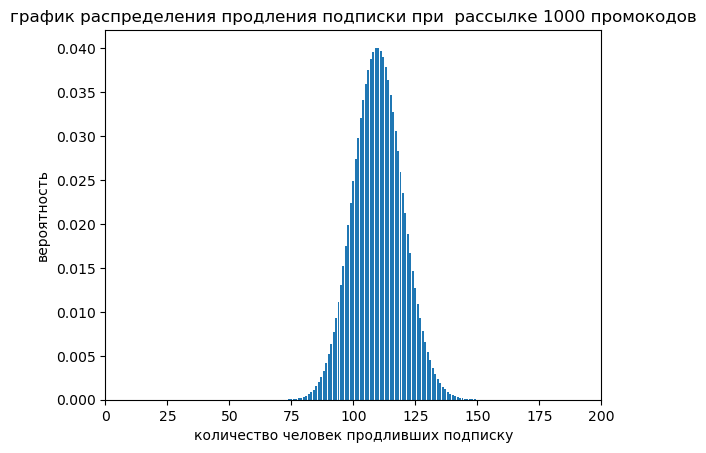

In [37]:
n = 1100 #количество промокодов
p = 0.1 #вероятноть успеха(того, что подписку продлят)

distr = [] #пустой список для построения бинминального распределения

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);
plt.xlim(0, 200)
plt.title('график распределения продления подписки при  рассылке 1000 промокодов')
plt.xlabel('количество человек продливших подписку')
plt.ylabel('вероятность');

Уже лучше.
Нам нужно провести расчеты, сколько промокодов нужно разослать, чтобы вероятность не выполнения плана была ~5%.

In [38]:

N = 1167 #количество промокодов
p = 0.1 #вероятноть успеха(того, что подписку продлят)

mu = N * p
sigma = (N * p * (1 - p)) ** 0.5

gr = st.norm(mu, sigma) 
x = 100

min_promo = gr.cdf(100)

min_promo

0.05160145525838272

#### Задача 2.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более  399,5 тыс. пользователей

In [39]:

from math import sqrt

n = 1000000 # параметры 
p = 0.4 # биномиального распределения

mu = n * p # рассчитайте параметры 
sigma = sqrt(n * p * (1 - p)) # нормального распределения

distr = st.norm(mu, sigma)# задайте нормальное распределение

result = 1 - distr.cdf(399500)# найдите вероятность
print(result)

0.8462829170363023


84% вероятность, что уведомлнние откроют не более 399.5 пользователей

## ОБЩИЙ ВЫВОД:

    Для данной работы мы получили данные пользователей приложения GoFast. 

3 дата фрейма:

- данные о пользователях приложения;
- данные о поездках;
- данные о подписках.

        Полученные данные были проверены на наличие дубликатов и пропусков. 

В таблице о пользователях начиная с 1534 строки содержаться полные дубликаты предыдущих.

Скорее всего это связано с технической ошибкой. Данную информацию необходимо передать в соотвествующий отдел.

Дубликаты удалены.

        Проведен исследовательский анализ данных. В результате которого установлено:

* Меньше всего пользователей приложения GoFast в Москве, всего 168.

Больше всего в Пятигорске - 219.

* Среди пользователей приложение 54% без подписки, против 46% с подпиской.

Пользователей без подписки больше, но всего процентов на 8, а значит у компании-прокатчика есть неплохая база постоянных клиентов.


* Среди пользователей чаще встречаются люди возраста от 20 до 28 лет.

Чаще остальных пользуются этим приложением 25-летние.

* Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.


* Чаще всего поездки длятся от 10 до 23 минут.

Пиковые значения: 12, 17 и 22 минуты.

Данные визуализированны графиками.


        На основании полученных данных созданы новые:

- Общий, 'general'. Включает в себя информацию о пользователях, о поездках и расшифровка тарифов. 

- 'ultra', Только информация о поездках пользователей с подпиской.

- 'free', Только информация о поездках пользователей без подписки.

- Визаулизировала на графиках данные о длительности и длине поездок пользователей без/с подпиской. По ним можно предположить, что у пользователей с подпиской эти показатели больше.


        Далее с помощью расчетов мы поработали с рядом гипотез:
        
* Подтвердили что длительность поездки пользователей с подпиской больше пользователей без подписки.

* Подтвердили, что длина поездок менее 3130 м.

* Подтвердили гипотезу о том, что выручка по месяцам пользователей с подпиской, больше чем выручка пользователей без подписки.

***Рекомендации:***

- В данных о поездках представлены всего 8 городов. Из них 4 миллионника. Стоит расширить географию использования приложения. Запустить пректы в прочих крупных городах (СПб, Новосибирск, Казань, Нижний Новогород, Уф, Воронеж, Пермь, ВОлгоград и пр). 

- Так же увеличивать число пользователей в уже имеющихся. Пользователей в Москве меньше чем пользователей в Пятигорске. Возможно стоит увеличить количество самокатов, или запустить дополнительную рекламу.

- Часть самокатов используется для коротких поездок. То есть это не прогулка, а целенапрвленная поездка добраться до какого-то место. Стоит проработать возможность запуска какой-то акции для коротких маршрутов. Возможно это будет абонемент на какое-то количество поедок до 1500 м, или же спец цены на поездки до конкретной точки. 

Пользователи которые используют самокаты для таких целей, озможно чаще станут приобретать абонементы и как следствие становится постоянными клиентами и сильнее интегрировать такое средство передвижения в свою жизнь.


- Есть пиковые значения по длительности поездки. Так же стоит отработать варианты фиксированных поездок 15, 20 и 25 минут.

- Поездки пользователей и длительность пользователей без подписки меньше. Можно повлиять на этот фактор. Длительные и длинные поездки, чаще используются для прогулочных вариантов. Можно начиная с определенного времени делать стоимость минуты дешевле. 


